In [1]:
import pandas as pd
import numpy as np
from gensim.models import FastText
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.initializers import Constant
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.utils import plot_model

In [2]:
import re

def preprocess_sentence(sentence, stopwords=None):
    # 개행자 삭제
    sentence = re.sub(r'[\n\r]', ' ', sentence)
    
    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다. 
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (a-z, A-Z,가-힣,0-9, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^a-zA-Z가-힣0-9\.\?\!,]", " ", sentence)
    sentence = sentence.strip()

    # '키키'와 같이 연속된 키를 제거합니다.
    sentence = re.sub(r'키{2,}', '', sentence)
    sentence = re.sub(r'\b키\b', '', sentence)

    if stopwords:
        words = sentence.split()
        filtered_words = [word for word in words if word not in stopwords]
        sentence = ' '.join(filtered_words)

    return sentence

In [3]:
# data
base_dir = '../data/'

train = pd.read_csv(base_dir + 'custom_train_2.csv')
test = pd.read_csv(base_dir + 'custom_test.csv')
test['conversation'] = test['conversation'].apply(preprocess_sentence)

In [4]:
all_texts = train['conversation'].tolist()

In [5]:
# We train FastText model on all_texts
fasttext_model = FastText(
    sentences=all_texts,
    vector_size=300,
    window=5,
    min_count=2,
    sg=1,
    word_ngrams=1,
    workers=4)

# Define Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_texts)
word_index = tokenizer.word_index



# EMBEDDING_DIM = 300  # this should match the dimensionality of the FastText vectors

# # Prepare embedding matrix
# embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
# for word, i in word_index.items():
#     if word in fasttext_model.wv:
#         embedding_vector = fasttext_model.wv[word]
#         embedding_matrix[i] = embedding_vector

# # Load this into an Embedding layer
# # Note that we set trainable=False to prevent the weights from being updated during training.

# embedding_layer = Embedding(len(word_index) + 1,
#                             EMBEDDING_DIM,
#                             embeddings_initializer=Constant(embedding_matrix),
#                             trainable=False)

In [6]:
def get_vector(model, texts):
    vectors = []
    for text in texts:
        text_vectors = []
        for word in text:
            if word in model.wv.key_to_index:
                text_vectors.append(model.wv.get_vector(word))
        if len(text_vectors) > 0:
            text_vector = np.mean(text_vectors, axis=0)
            vectors.append(text_vector)
        else:
            vectors.append(np.zeros(model.vector_size))
    return np.array(vectors)

In [7]:
X_train = get_vector(fasttext_model, train['conversation'])
Y_train = tf.keras.utils.to_categorical(train['label'])
X_test = get_vector(fasttext_model, test['conversation'])

In [8]:
fasttext_model.vector_size

300

In [9]:
X_train.shape

(9900, 300)

In [10]:
len(fasttext_model.wv.key_to_index)

1531

In [11]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=123)

# Model Define

In [12]:
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    # 예측값을 0과 1로 반올림
    y_pred = tf.round(y_pred)

    # True Positives, False Positives, False Negatives 계산
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

    # Precision, Recall 계산
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    # F1 Score 계산
    f1_val = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    return f1_val

In [13]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

In [14]:
X_train.shape

(7920, 1, 300)

In [15]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

In [16]:
# sweep_config = {
#     "name": "fasttext_gesim_sweep_1",
#     'method': 'bayes',  # Random search 방식으로 하이퍼파라미터 탐색
#     'metric': {
#         'name': 'accuracy',
#         'goal': 'maximize'
#     },
#     'parameters': {
#         'lr': {
#             'values': [0.01, 0.05, 0.1, 0.2, 0.5]  # 더 넓은 범위의 학습률
#         },
#         'epoch': {
#             'values': [50, 70, 100]  # 다양한 에포크 수
#         },
#         'wordNgrams': {
#             'values': [2, 3, 4]  # 다양한 n-그램 값
#         },
#         'dim': {
#             'values': [100, 150, 200]  # 다양한 벡터 차원
#         },
#         'minCount': {
#             'values': [1, 2, 3, 5, 7]  # 다양한 최소 단어 출현 빈도
#         }
#     }
# }


In [17]:
"""
wandb: Agent Starting Run: vbpucc3r with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	learning_rate: 0.0021717954296463227
wandb: 	units: 128
"""
batch_size = 16
dropout_rate = 0.3
learning_rate = 0.002
units = 64

In [18]:
# Define the model architecture
model = Sequential()
model.add(LSTM(units, return_sequences=True, input_shape=(1, X_train.shape[2])))
model.add(Dropout(dropout_rate))
model.add(LSTM(units))
model.add(Dropout(dropout_rate))
model.add(Dense(Y_train.shape[1], activation='softmax'))

optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy',f1_score])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 64)             93440     
_________________________________________________________________
dropout (Dropout)            (None, 1, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 126,789
Trainable params: 126,789
Non-trainable params: 0
_________________________________________________________________


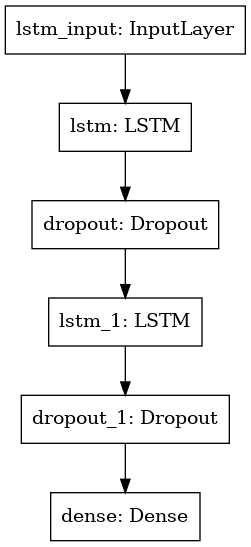

In [19]:
model.summary()

plot_model(model)

In [20]:
# Define early stopping
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=5, min_delta=0.0001)

# Train the model
history = model.fit(X_train, Y_train,
          epochs=50,
          batch_size=batch_size,
          validation_data=(X_val, Y_val),
          callbacks=[es]
         )

Epoch 1/50
495/495 [==============================] - 10s 6ms/step - loss: 1.2857 - accuracy: 0.4480 - f1_score: 0.2481 - val_loss: 0.9789 - val_accuracy: 0.6258 - val_f1_score: 0.5370
Epoch 2/50
495/495 [==============================] - 2s 5ms/step - loss: 0.9042 - accuracy: 0.6528 - f1_score: 0.5995 - val_loss: 0.8616 - val_accuracy: 0.6460 - val_f1_score: 0.6229
Epoch 3/50
495/495 [==============================] - 3s 6ms/step - loss: 0.8222 - accuracy: 0.6902 - f1_score: 0.6635 - val_loss: 0.7758 - val_accuracy: 0.7015 - val_f1_score: 0.6743
Epoch 4/50
495/495 [==============================] - 2s 5ms/step - loss: 0.7830 - accuracy: 0.7047 - f1_score: 0.6853 - val_loss: 0.7110 - val_accuracy: 0.7313 - val_f1_score: 0.7181
Epoch 5/50
495/495 [==============================] - 2s 5ms/step - loss: 0.7582 - accuracy: 0.7191 - f1_score: 0.6990 - val_loss: 0.7100 - val_accuracy: 0.7273 - val_f1_score: 0.7116
Epoch 6/50
495/495 [==============================] - 2s 5ms/step - loss: 0.736

In [21]:
# Evaluate the model
accuracy = model.evaluate(X_val, Y_val, verbose=0)[1]


accuracy

0.758080780506134

In [22]:
predictions = model.predict(X_test)
predictions

array([[9.46574435e-02, 6.16417825e-01, 2.74304133e-02, 2.59865105e-01,
        1.62915746e-03],
       [1.55234104e-02, 1.09658102e-02, 9.57745135e-01, 1.50925480e-02,
        6.73208153e-04],
       [9.15761441e-02, 7.77550116e-02, 7.63085485e-01, 6.42192811e-02,
        3.36411898e-03],
       ...,
       [1.58467460e-02, 9.34527636e-01, 9.15217213e-04, 4.87028472e-02,
        7.62759873e-06],
       [2.95528680e-01, 1.08829908e-01, 4.24582869e-01, 1.55558243e-01,
        1.55002549e-02],
       [5.31551361e-01, 2.09747970e-01, 1.14796147e-01, 1.30488828e-01,
        1.34157045e-02]], dtype=float32)

# submission

In [23]:
submission = pd.read_csv(base_dir + 'submission.csv')

predicted_classes = np.argmax(predictions, axis=1)

submission['class'] = predicted_classes

submission['class'].value_counts()

3    137
2    129
1    114
0     63
4     57
Name: class, dtype: int64

In [24]:
submission.to_csv('fasttext_lstm_submission.csv', index=False)

# numpy 저장용

In [25]:
import numpy as np

np.save('fasttext_lstm_predictions', predictions)

In [26]:
import numpy as np
predictions = np.load('fasttext_lstm_predictions.npy')
print(predictions.shape)


# for pred in predictions:
#     print(np.argmax(pred))

(500, 5)
